<a href="https://colab.research.google.com/github/chen2369/data-course-sample/blob/main/content_based_%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-02 09:36:05--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.5’

All_Beauty.csv.5    100%[===================>]  14.78M  23.2MB/s    in 0.6s    

2022-01-02 09:36:06 (23.2 MB/s) - ‘All_Beauty.csv.5’ saved [15499476/15499476]

--2022-01-02 09:36:06--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.5’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.9MB/s    in 0.5s   

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

metadata -> metadata_clean

In [7]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [8]:
import numpy as np

def emptylist_na(cell):
    try:
        if len(cell) == 0:
            return np.nan
        else:
            return cell
    except:
        return cell
metadata_na = metadata.applymap(emptylist_na)

In [9]:
metadata_na.isna().sum().sort_values(ascending=False).to_frame(name='Number of NA').T

,category,tech2,fit,tech1,date,feature,similar_item,also_buy,also_view,price,description,imageURLHighRes,imageURL,brand,rank,details,title,main_cat,asin
Number of NA,32892,32892,32892,32882,32873,32623,31588,26295,24760,21433,17773,16351,16351,15673,377,132,1,0,0


In [10]:
print('# main_cat:', metadata['main_cat'].unique())
print('# similar_item:', metadata['similar_item'].unique())
print('# details:', metadata['details'].sample(5))

# main_cat: ['All Beauty']
# similar_item: [''
 ' class="a-bordered a-horizontal-stripes  a-spacing-extra-large a-size-base comparison_table">\n\n\n\n            \n            \n            \n            \n            \n            <tr class="comparison_table_image_row">\n                <td class="comparison_table_first_col"></td>\n\n\n                <th class="comparison_image_title_cell" role="columnheader">\n                    <div class="a-row a-spacing-top-micro">\n                        <center>\n                             <img alt="No7 Lift &amp; Luminate Triple Action Serum 50ml by Boots" src="https://images-na.ssl-images-amazon.com/images/I/31gXVsxM7FL._SL500_AC_SS350_.jpg" id="comparison_image">\n                        </center>\n                    </div>\n                    <div class="a-row a-spacing-top-small">\n                        <div id="comparison_title" class="a-section a-spacing-none">\n                            <span aria-hidden="true" class="a-size-b

In [11]:
metadata.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]


In [12]:
(metadata.asin.value_counts()!=1).sum()

404

In [13]:
metadata_clean = metadata[['asin', 'title', 'description', 'rank', 'brand', 'price', 'also_view', 'also_buy']]
metadata_clean = metadata_clean.drop_duplicates('asin')
metadata_clean.head(1)

,asin,title,description,rank,brand,price,also_view,also_buy
0,6546546450,Loud 'N Clear&trade; Personal Sound Amplifier,[Loud 'N Clear Personal Sound Amplifier allows...,"2,938,573 in Beauty & Personal Care (",idea village,,[],[]


In [14]:
metadata_clean['description'] = metadata_clean['description'].apply(lambda x: ''.join(x))
metadata_clean['text'] = metadata_clean['title'] + metadata_clean['description']
# metadata_clean['text'] = metadata_clean['title']
# metadata_clean['text'] = metadata_clean['description']
metadata_clean['text'] = metadata_clean['text'].apply(lambda x: x.lower())

In [15]:
metadata_clean['price'] = metadata_clean['price'].str.replace('$', '')
metadata_clean['price'] = pd.to_numeric(metadata_clean['price'], errors = 'coerce')

In [16]:
metadata_clean['cate'] = metadata_clean['rank'].str.split(' in ').str[1]
metadata_clean['cate'] = metadata_clean['cate'].str.replace('amp;', '')
metadata_clean['cate'] = metadata_clean['cate'].str.replace(' \(', '')
metadata_clean['cate'].unique()

array(['Beauty & Personal Care', nan, 'Grocery & Gourmet Food',
       'Health & Household', 'Sports & Outdoors', 'Toys & Games', 'Baby',
       'Clothing, Shoes & Jewelry', 'Home & Kitchen', 'Automotive',
       'Tools & Home Improvement'], dtype=object)

In [17]:
metadata_clean['rank'] = metadata_clean['rank'].str.split(expand = True)[0]
metadata_clean['rank'] = metadata_clean['rank'].str.replace(',', '')
metadata_clean['rank'] = pd.to_numeric(metadata_clean['rank'])

In [18]:
metadata_clean.head(1)

,asin,title,description,rank,brand,price,also_view,also_buy,text,cate
0,6546546450,Loud 'N Clear&trade; Personal Sound Amplifier,Loud 'N Clear Personal Sound Amplifier allows ...,2938573.0,idea village,NaN,[],[],loud 'n clear&trade; personal sound amplifierl...,Beauty & Personal Care


## 資料切分

ratings_trainings

In [19]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_trainings.drop_duplicates(inplace=True)
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [20]:
users_training = ratings_trainings['reviewerID'].unique()

In [21]:
ratings_trainings['asin'].value_counts().describe()

count    32582.000000
mean        11.100669
std         95.092360
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       8667.000000
Name: asin, dtype: float64

In [22]:
ratings_trainings['overall'].describe()

count    361682.000000
mean          4.107785
std           1.364594
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

## Metadata 樣態分析

依照上次rule-based經驗，採用前兩個月的資料來作分析

### 讀取資料

In [23]:
import datetime
training_data = ratings_trainings[(ratings_trainings['DATE'] + datetime.timedelta(days = 9999)) > '2018-09-01']
ratehot_table = training_data.groupby(by = ['asin']).aggregate({'overall':['mean', 'size']})['overall']
metadata_clean = pd.merge(metadata_clean, ratehot_table, on='asin', how='left')
metadata_clean.sort_values(['size'], ascending=False, inplace=True)

In [24]:
df = pd.merge(training_data, metadata_clean[['asin', 'cate', 'brand', 'price', 'rank', 'mean', 'size']], on='asin', how='left')
df.loc[np.isnan(df['size']), 'size'] = 0
df.shape

(361682, 11)

In [25]:
df.sample(5)

,asin,reviewerID,overall,unixReviewTime,DATE,cate,brand,price,rank,mean,size
39372,B000GLRREU,A1DWAI9V6IS7JZ,5.0,1304467200,2011-05-04,Beauty & Personal Care,Waterpik,NaN,20356.0,4.405107,8341.0
21211,B0009MFUOA,A2802HG1Y0BGU6,3.0,1179100800,2007-05-14,Beauty & Personal Care,Philips Norelco,18.23,702129.0,3.971496,421.0
87973,B004BD9152,A2NWG3UDO5T4BW,5.0,1415750400,2014-11-12,Beauty & Personal Care,L'Oreal Paris,5.37,167810.0,4.395833,288.0
169991,B00PMUTNOM,A35AHTPLH9FRSV,5.0,1466553600,2016-06-22,Beauty & Personal Care,Happylifehere,10.99,71644.0,4.147059,102.0
41529,B000H6A02A,A1E416M0G2AH9R,2.0,1412294400,2014-10-03,Beauty & Personal Care,Remington,NaN,412099.0,3.599178,973.0


### 分類與品牌

- 分類只取 Beauty & Personal Care
- 不依照品牌作相似的推薦

總共有的品牌跟類別

In [26]:
print('brand:', len(metadata_clean['brand'].unique())-1) # nan
print('cate:', len(metadata_clean['cate'].unique())-1) # nan

brand: 7862
cate: 10


可以直接排除掉美妝以外的商品

In [27]:
df.groupby('cate')['asin'].count()

cate
Automotive                       13
Baby                              2
Beauty & Personal Care       352006
Clothing, Shoes & Jewelry         9
Grocery & Gourmet Food          245
Health & Household              125
Home & Kitchen                    1
Sports & Outdoors                18
Tools & Home Improvement          7
Toys & Games                      9
Name: asin, dtype: int64

熱銷的商品不太會帶起該品牌其他商品

In [28]:
df.groupby('brand')['asin'].count().nlargest(10)

brand
                   86524
Waterpik           17056
Philips Norelco    12419
Astra               4576
Pre de Provence     3398
Aquaphor            2882
Braun               2636
Gillette            2488
Panasonic           2473
Helen Of Troy       2291
Name: asin, dtype: int64

In [29]:
df[df['brand'] != ""].drop_duplicates().groupby([df['DATE'].dt.strftime('%B'), df['brand']])['asin'].count().nlargest(10)

DATE       brand          
January    Waterpik           1767
December   Waterpik           1718
January    Philips Norelco    1565
February   Waterpik           1514
March      Waterpik           1448
August     Waterpik           1434
July       Waterpik           1366
November   Waterpik           1359
September  Waterpik           1332
April      Waterpik           1328
Name: asin, dtype: int64

In [30]:
df[df['brand']=='Waterpik']['size'].describe()

count    17056.000000
mean      8483.252697
std        477.929165
min          3.000000
25%       8341.000000
50%       8667.000000
75%       8667.000000
max       8667.000000
Name: size, dtype: float64

購買多個同品牌商品，通常都是在同一天的訂單，故若只單純就熱銷推薦，不適合直接推薦許多同品牌商品

In [31]:
topuser = df.reviewerID.value_counts().keys()[:5]
df[df['reviewerID'].isin(topuser)].sort_values('reviewerID')

,asin,reviewerID,overall,unixReviewTime,DATE,cate,brand,price,rank,mean,size
184945,B00W259T7G,A1EGCED01USBA9,5.0,1416182400,2014-11-17,Beauty & Personal Care,Pre de Provence,4.99,130823.0,4.497835,2772.0
331587,B016HCSTU2,A1EGCED01USBA9,5.0,1455580800,2016-02-16,Beauty & Personal Care,,NaN,1648201.0,5.000000,1.0
184894,B00W259T7G,A1EGCED01USBA9,4.0,1419724800,2014-12-28,Beauty & Personal Care,Pre de Provence,4.99,130823.0,4.497835,2772.0
333611,B017DN324M,A1EGCED01USBA9,5.0,1455580800,2016-02-16,Beauty & Personal Care,,NaN,2101688.0,5.000000,1.0
89436,B004LUQRJI,A1EGCED01USBA9,5.0,1476144000,2016-10-11,Beauty & Personal Care,Paul Brown Hawaii,NaN,876376.0,4.984190,253.0
...,...,...,...,...,...,...,...,...,...,...,...
141599,B00FXTE88S,AENH50GW3OKDA,5.0,1445990400,2015-10-28,Beauty & Personal Care,Diva Stuff,11.80,204508.0,3.892308,65.0
187585,B00X918PRC,AENH50GW3OKDA,5.0,1440460800,2015-08-25,Beauty & Personal Care,,NaN,469112.0,4.032258,31.0
168020,B00OR1D37A,AENH50GW3OKDA,5.0,1432166400,2015-05-21,Beauty & Personal Care,Organic Fields Of Heather,NaN,275838.0,3.273438,128.0
177062,B00TP79D7A,AENH50GW3OKDA,5.0,1440806400,2015-08-29,Beauty & Personal Care,,NaN,613995.0,3.448276,29.0


### 價格與排名

- 有9成5的商品均在50元以下，並且從散佈圖看來，銷量最好的產品也多在50元以下
- 排名部分沒有明顯的關係，因此暫不列入考量

In [32]:
df.isna().sum().sort_values(ascending=False).to_frame(name='Number of NA').T

,price,rank,cate,mean,brand,size,DATE,unixReviewTime,overall,reviewerID,asin
Number of NA,181648,9247,9247,5120,5120,0,0,0,0,0,0


In [33]:
df_price = df[df['price'].isna() == False]
df_rank = df[df['rank'].isna() == False]

In [34]:
print(df_price.shape)
df_price['price'].describe()

(180034, 11)


count    180034.000000
mean         19.046414
std          32.492772
min           0.010000
25%           7.490000
50%          11.990000
75%          20.790000
max         999.990000
Name: price, dtype: float64

In [35]:
df_price['price'].quantile(.95)

50.459999999999994

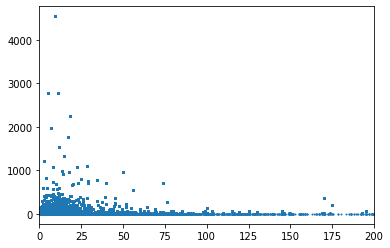

In [36]:
import matplotlib.pyplot as plt
plt.scatter(df_price['price'], df_price['size'], s=1)
plt.xlim(0, 200)
plt.show()

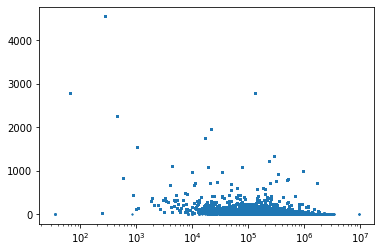

In [37]:
plt.scatter(df_price['rank'], df_price['size'], s=1)
plt.xscale('log')
plt.show()

### 評價

- 5分評論佔據6成
- 從各商品平均評價分數來看，5分確實是最多人買的，不過3分以上的商品也有不錯的購買量
- 可能可以選擇兩種標準觀察何者更佳


In [38]:
df[np.isnan(df['mean']) == False].shape

(356562, 11)

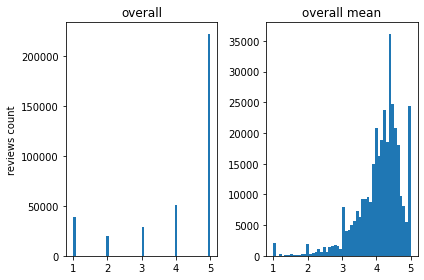

In [39]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df['overall'], bins=50)
ax1.set_title('overall')
ax1.set_ylabel('reviews count')
ax2.hist(df['mean'], bins=50)
ax2.set_title('overall mean')
fig.tight_layout()

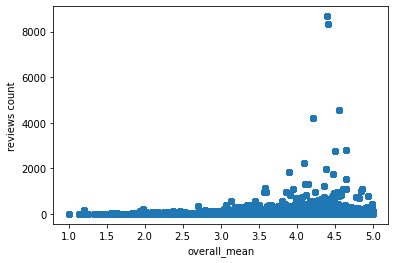

In [40]:
plt.scatter(df['mean'], df['size'])
plt.xlabel('overall_mean')
plt.ylabel('reviews count')
plt.show()

## 字詞分析

In [41]:
!pip install nltk

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import re

def cleanhtml(raw_html):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

def text2token(text):
    tokens = []
    stopword_list_eng = stopwords.words('english')
    wordnet = WordNetLemmatizer()

    try:
        text = word_tokenize(text)
    except:
       return []

    for token, tag in pos_tag(text):
        pos = tag[0]
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        
        t = wordnet.lemmatize(token,pos)
        if t not in stopword_list_eng and t.isalpha():
            tokens.append(t)

    return tokens

In [43]:
has_des = (metadata_clean['text'].notnull())
metadata_clean.loc[has_des, 'text'] = metadata_clean.loc[has_des, 'text'].apply(lambda x: cleanhtml(x))

In [44]:
metadata_clean['text_token'] = metadata_clean['text'].apply(text2token)
metadata_clean['text_clean'] = metadata_clean['text_token'].apply(lambda x: ' '.join(x))

In [45]:
metadata_clean.head(3)

,asin,title,description,rank,brand,price,also_view,also_buy,text,cate,mean,size,text_token,text_clean
850,B000FOI48G,Waterpik Ultra Water Flosser,Premium dental water jet with dramatically imp...,19437.0,Waterpik,NaN,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",waterpik ultra water flosserpremium dental wat...,Beauty & Personal Care,4.394369,8667.0,"[waterpik, ultra, water, flosserpremium, denta...",waterpik ultra water flosserpremium dental wat...
970,B000GLRREU,Waterpik Ultra Water Flosser,Premium dental water jet with dramatically imp...,20356.0,Waterpik,NaN,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",waterpik ultra water flosserpremium dental wat...,Beauty & Personal Care,4.405107,8341.0,"[waterpik, ultra, water, flosserpremium, denta...",waterpik ultra water flosserpremium dental wat...
3202,B001QY8QXM,Astra Platinum Double Edge Safety Razor Blades...,ASTRA stainless double edge blades fit all dou...,280.0,Astra,9.3,"[B00DQ2W7UK, B00PKHIDRA, B07CGMTVM4, B07MB4LZC...",[],astra platinum double edge safety razor blades...,Beauty & Personal Care,4.555923,4542.0,"[astra, platinum, double, edge, safety, razor,...",astra platinum double edge safety razor blade ...


In [46]:
from collections import Counter

tokens = np.concatenate(np.array(metadata_clean['text_token'])).tolist()
word_count = Counter(tokens)
print(word_count.most_common(50))

[('skin', 9798), ('hair', 9304), ('oil', 5925), ('oz', 5369), ('color', 5116), ('body', 4612), ('pack', 4322), ('natural', 4028), ('nail', 3930), ('product', 3582), ('use', 3518), ('set', 3182), ('black', 2975), ('cream', 2738), ('woman', 2717), ('brush', 2695), ('size', 2690), ('lip', 2527), ('new', 2465), ('help', 2364), ('eye', 2343), ('gel', 2281), ('face', 2237), ('quality', 2121), ('free', 2103), ('x', 2076), ('soap', 2056), ('makeup', 2023), ('fragrance', 2017), ('dry', 2001), ('one', 1990), ('made', 1901), ('ha', 1841), ('make', 1815), ('water', 1814), ('spray', 1781), ('soft', 1756), ('perfect', 1753), ('clean', 1746), ('beauty', 1711), ('care', 1686), ('long', 1672), ('day', 1655), ('white', 1628), ('formula', 1606), ('organic', 1605), ('ingredient', 1600), ('high', 1594), ('essential', 1553), ('hand', 1532)]


## 將Metadata做篩選

分為
- 評分3以上 metadata_clean_3
- 評分5分 metadata_clean_5

In [47]:
metadata_clean.shape

(32488, 14)

In [48]:
metadata_clean = metadata_clean[metadata_clean['cate'] == 'Beauty & Personal Care']
metadata_clean.shape

(32015, 14)

In [49]:
metadata_clean = metadata_clean[(metadata_clean['price'] > 50) == False]
metadata_clean.shape

(30766, 14)

In [50]:
metadata_clean_3 = metadata_clean[(metadata_clean['mean'] < 3) == False]
metadata_clean_3.shape

(26499, 14)

In [51]:
metadata_clean_5 = metadata_clean[(metadata_clean['mean'] < 5) == False]
metadata_clean_5.shape

(11512, 14)

## 產生推薦

### 相似分群

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
df = metadata_clean.drop_duplicates('title').reset_index(drop=True)
tf = TfidfVectorizer(analyzer='word', min_df = 100)
tfidf_matrix = tf.fit_transform(df['text_clean'])
f = tfidf_matrix.toarray()

df1 = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
res = pd.concat([df, df1], axis=1)
res.head(1)

,asin,title,description,rank,brand,price,also_view,also_buy,text,cate,mean,size,text_token,text_clean,accessory,achieve,acid,acne,acrylic,act,action,active,actual,add,added,addition,adhesive,adjust,adjustable,adult,advanced,age,agent,aging,aid,air,alcohol,allow,allows,alloy,...,water,waterproof,wave,wavy,wax,way,wear,wearing,wedding,week,weight,well,wet,white,whitening,whole,wide,wig,wild,winter,wipe,within,without,wo,woman,wonderful,wood,work,working,world,worldwide,would,wrap,wrinkle,wrist,year,yellow,yet,youthful,zipper
0,B000FOI48G,Waterpik Ultra Water Flosser,Premium dental water jet with dramatically imp...,19437.0,Waterpik,NaN,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",waterpik ultra water flosserpremium dental wat...,Beauty & Personal Care,4.394369,8667.0,"[waterpik, ultra, water, flosserpremium, denta...",waterpik ultra water flosserpremium dental wat...,0.032263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038426,0.0,0.0,0.0,0.0,0.0,0.0,0.078539,0.0,0.0,0.0,0.0,...,0.487368,0.0,0.0,0.0,0.0,0.065942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036615,0.0,0.0,0.0,0.0,0.0,0.034384,0.0,0.0,0.0,0.0


In [54]:
from sklearn.cluster import AgglomerativeClustering
m_agg = AgglomerativeClustering(n_clusters=10)
res_agg = m_agg.fit_predict(f)

In [55]:
from sklearn.cluster import KMeans
kmn = KMeans(n_clusters=10, random_state=0)
res_kmn = kmn.fit_predict(f)

In [57]:
metadata_clean['aggclus'] = pd.Series(res_agg)
metadata_clean['kmnclus'] = pd.Series(res_kmn)
metadata_clean.head(1)

,asin,title,description,rank,brand,price,also_view,also_buy,text,cate,mean,size,text_token,text_clean,aggclus,kmnclus
850,B000FOI48G,Waterpik Ultra Water Flosser,Premium dental water jet with dramatically imp...,19437.0,Waterpik,NaN,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...","[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",waterpik ultra water flosserpremium dental wat...,Beauty & Personal Care,4.394369,8667.0,"[waterpik, ultra, water, flosserpremium, denta...",waterpik ultra water flosserpremium dental wat...,3.0,7.0


### 相似度計算

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
df = metadata_clean.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word', min_df = 100)
tfidf_matrix = tf.fit_transform(df['text_clean'])

# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df['text_clean'])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res


In [ ]:
# for ele1, ele2 in zip(tf.get_feature_names()[:10], tf.idf_[:10]):
#     print(ele1, ':', ele2)

00 : 7.511652457575936
000 : 8.610264746244045
0000 : 9.996559107363936
00000 : 10.284241179815718
0001 : 10.689706287923881
00020 : 10.689706287923881
0003 : 10.284241179815718
0006 : 10.689706287923881
000835 : 10.689706287923881
000iu : 10.689706287923881


In [ ]:
for ele1, ele2 in zip(tf.get_feature_names()[:10], tf.idf_[:10]):
    print(ele1, ':', ele2)

ability : 6.728893118326304
accessories : 5.906389916552316
accessory : 5.206986198378066
achieve : 6.35897294763755
acid : 5.01124162125197
acne : 5.5687229366587605
acrylic : 5.52206724501796
act : 6.71941437437176
action : 5.885685243190625
active : 5.74449879915008


### 推薦

In [157]:
import datetime
def recommender(training_data, metadata, clus, users_training=[], users=[], group=0, score=5, k=10, rule='', days=60):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    # metadata = metadata.drop(['mean', 'size'], axis=1)
    training_data = training_data[(training_data['DATE'] + datetime.timedelta(days = days)) > '2018-09-01']
    ratehot_table = training_data.groupby(by = ['asin']).aggregate({'overall':['mean', 'size']})['overall']
    metadata = pd.merge(metadata, ratehot_table, on='asin', how='left')
    metadata = metadata.sort_values(['size'], ascending=False)
    metadata = metadata[(metadata['mean']<score) == False]
    metadata = metadata[metadata[clus+"clus"]==group]

    recommendations = {user: metadata['asin'].tolist()[:k] for user in users}    
    
    ratings_trainings = training_data
    if rule == 'personal_recommend':
        recommendations = {user: recommend_items(metadata[metadata['asin'].isin(sorted(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist(), reverse=True))]['text_clean'].tolist(), k) for user in users if user in users_training}
    
    return recommendations

## 結果評估

In [142]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

## 結果比較

#### 用使用者購買記錄做相似商品推薦

In [81]:
ratings_by_user = recommender(ratings_trainings, metadata_clean, users_training, users, rule='personal_recommend')
evaluate(ratings_testings_by_user, ratings_by_user)

0.0


### 觀察不同分群的結果

#### kmeans

In [148]:
for g in range(10):
    ratings_by_user = recommender(training_data = ratings_trainings, metadata = metadata_clean, users = users, clus='kmn', group=g, score=3, k=10, days=60)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    print('g=%d, score=%.5f' %(g, score))

g=0, score=0.13390
g=1, score=0.02034
g=2, score=0.04746
g=3, score=0.00339
g=4, score=0.01695
g=5, score=0.00169
g=6, score=0.00847
g=7, score=0.00169
g=8, score=0.03559
g=9, score=0.01017


#### agglomerative

In [151]:
for g in range(10):
    ratings_by_user = recommender(training_data = ratings_trainings, metadata = metadata_clean, users = users, clus='agg', group=g, score=3, k=10, days=60)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    print('g=%d, score=%.5f' %(g, score))

g=0, score=0.15085
g=1, score=0.02034
g=2, score=0.00847
g=3, score=0.00678
g=4, score=0.00847
g=5, score=0.00169
g=6, score=0.02881
g=7, score=0.00169
g=8, score=0.00339
g=9, score=0.01695


### 觀察不同評分、時間長度的結果

In [162]:
slst = [3, 4, 5]
dlst = [10, 15, 20, 30, 60, 180]
for s in slst:
    for d in dlst:
        ratings_by_user = recommender(training_data = ratings_trainings, metadata = metadata_clean, users = users, clus='agg', group=0, score=s, k=10, days=d)
        score = evaluate(ratings_testings_by_user, ratings_by_user)
        print('s=%d day=%d, score=%.5f' %(s, d, score))

s=3 day=10, score=0.15763
s=3 day=15, score=0.16780
s=3 day=20, score=0.15593
s=3 day=30, score=0.12712
s=3 day=60, score=0.15085
s=3 day=180, score=0.08305
s=4 day=10, score=0.07797
s=4 day=15, score=0.17119
s=4 day=20, score=0.10169
s=4 day=30, score=0.14746
s=4 day=60, score=0.05593
s=4 day=180, score=0.02034
s=5 day=10, score=0.01017
s=5 day=15, score=0.01017
s=5 day=20, score=0.01695
s=5 day=30, score=0.01695
s=5 day=60, score=0.00508
s=5 day=180, score=0.00000


In [164]:
for k in range(10, 51, 10):
    ratings_by_user = recommender(training_data = ratings_trainings, metadata = metadata_clean, users = users, clus='agg', group=0, score=3, k=k, days=15)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    print(score)

0.16779661016949152
0.19152542372881357
0.20508474576271185
0.21016949152542372
0.21016949152542372
